In [2]:
import tensorflow as tf

In [3]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
# Import TensorFlow and tf.keras

from matplotlib.pyplot import imshow
from numpy.random import default_rng

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from tensorflow import keras


from tensorflow.python.keras import layers
from keras._tf_keras.keras.preprocessing import image
from keras._tf_keras.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Input, Dense, Activation, Flatten, Conv2D
from tensorflow.python.keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.python.keras.models import Model

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential

from tensorflow.python.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras._tf_keras.keras.optimizers import Adam, SGD
from keras._tf_keras.keras.applications import mobilenet
from keras._tf_keras.keras.applications.mobilenet import preprocess_input

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [4]:
inputPath = r"D:\DoAnChuyenNganh_TTNT"

In [5]:
#load only persons with more than "number_of_images"
number_of_images = 50
aug_multiplier = 10
iter_csv = pd.read_csv(inputPath+"/lfw_allnames.csv", iterator=True, chunksize=1000)
df = pd.concat([chunk[chunk['images'] > number_of_images] for chunk in iter_csv])
df.head()

,name,images
373,Ariel_Sharon,77
1047,Colin_Powell,236
1404,Donald_Rumsfeld,121
1871,George_W_Bush,530
1892,Gerhard_Schroeder,109


In [6]:
df.shape[0]

12

In [7]:
imagesFolder = inputPath+"/lfw_funneled/"
imagesFolder

'D:\\DoAnChuyenNganh_TTNT/lfw_funneled/'

In [8]:
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    #print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse_output=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    #print(onehot_encoded)

    y = onehot_encoded
    # print(y.shape)
    return y

In [9]:
tr_len = (df.shape[0]*number_of_images*aug_multiplier)-(number_of_images*df.shape[0])
y_tr = ["" for x in range(tr_len)]

ts_len = df.shape[0]*number_of_images
y_ts = ["" for x in range(ts_len)]

In [10]:
df['name']

373          Ariel_Sharon
1047         Colin_Powell
1404      Donald_Rumsfeld
1871        George_W_Bush
1892    Gerhard_Schroeder
2175          Hugo_Chavez
2288       Jacques_Chirac
2468        Jean_Chretien
2682        John_Ashcroft
2941    Junichiro_Koizumi
4963      Serena_Williams
5458           Tony_Blair
Name: name, dtype: object

In [11]:
tr_len

5400

In [12]:
rng = default_rng()
X_rand = rng.choice(number_of_images*aug_multiplier, size=number_of_images, replace=False)
X_rand.sort()
X_rand

array([  7,  19,  28,  44,  50,  58,  59,  72,  94,  97, 111, 119, 133,
       142, 144, 150, 161, 164, 176, 184, 194, 219, 237, 243, 252, 255,
       263, 274, 286, 313, 315, 330, 346, 349, 353, 362, 377, 391, 395,
       418, 427, 428, 430, 437, 446, 447, 456, 478, 485, 490])

In [13]:
def prepareImages(df, m):
    print("Preparing images")
    X_train = np.zeros((tr_len, 250, 250, 3))
    X_test = np.zeros((ts_len, 250, 250, 3))
    
    count = 0
    ts_idx = 0
    tr_idx = 0
    
    for personFolder in df['name']:
        print(personFolder)
        #count = 0
        rng = default_rng()
        X_rand = rng.choice(number_of_images*aug_multiplier, size=number_of_images, replace=False)
        X_rand.sort()
        rand_idx = 0
        person_images_idx = 0
        for img in os.listdir(imagesFolder+"/"+personFolder):
            
            #load images into images of size 100x100x3
            img = image.load_img(imagesFolder+personFolder+"/"+img, target_size=(250, 250, 3))
            x = image.img_to_array(img)
            x = preprocess_input(x)
            if (person_images_idx == X_rand[rand_idx]):
                X_test[ts_idx] = x
                y_ts[ts_idx] = personFolder
                ts_idx += 1
                #print(ts_idx)
                if rand_idx<number_of_images-1:
                    rand_idx += 1
                
            else:
                X_train[tr_idx] = x
                #print("else\n")
                y_tr[tr_idx] = personFolder
                tr_idx += 1
            count += 1
            person_images_idx += 1
            #print(count)
            if (count % ((number_of_images*aug_multiplier)) == 0):
                print("Processing image: ", count, ", ", img)
                break
            
    
    return X_train, X_test

In [14]:
X_train,X_test = prepareImages(df, df.shape[0]*number_of_images*aug_multiplier)

y_train = prepare_labels(y_tr)

y_test = prepare_labels(y_ts)

df['name']

Preparing images
Ariel_Sharon
Colin_Powell
Donald_Rumsfeld
George_W_Bush
Processing image:  500 ,  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x227327DE320>
Gerhard_Schroeder
Hugo_Chavez
Jacques_Chirac
Jean_Chretien
John_Ashcroft
Junichiro_Koizumi
Serena_Williams
Tony_Blair
Processing image:  1000 ,  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x227327DC4C0>


373          Ariel_Sharon
1047         Colin_Powell
1404      Donald_Rumsfeld
1871        George_W_Bush
1892    Gerhard_Schroeder
2175          Hugo_Chavez
2288       Jacques_Chirac
2468        Jean_Chretien
2682        John_Ashcroft
2941    Junichiro_Koizumi
4963      Serena_Williams
5458           Tony_Blair
Name: name, dtype: object

In [15]:
y_train.shape

(5400, 13)

In [16]:
X_train.shape

(5400, 250, 250, 3)

In [17]:
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
# create a data generator
datagen = ImageDataGenerator()
print(datagen)

In [18]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [19]:
nr_classes = y_train.shape[1]
model = mobilenet.MobileNet(input_shape=(250, 250, 3), weights=None, include_top=True, alpha=1., classes=nr_classes)
model.compile(optimizer=Adam(learning_rate=0.0008), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy])
#model.load_model("AI\algorithm\working/model_25gpunotop.h5")
print(model.summary())

Model: "mobilenet_1.00_250"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 125, 125, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 125, 125, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 125, 125, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 125, 125, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 125, 125, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 62, 62, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 62, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 62, 62, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 62, 62, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 62, 62, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,242,189 (12.37 MB)

 Trainable params: 3,220,301 (12.28 MB)

 Non-trainable params: 21,888 (85.50 KB)

None


In [20]:
len(X_train)

5400

In [21]:
BS=100
steps = len(X_train) / BS
steps

54.0

In [22]:
steps = len(X_train) / BS

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)
# history = model.fit(datagen.flow(X_train, y_train, batch_size=BS), validation_data=(X_test, y_test), epochs=10, verbose=1)
model.save(r"AI\algorithm\working/model_25gpunotop.h5")
#model.load_model("AI\algorithm\working/model_25gpunotop.h5")

Epoch 1/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 483s 3s/step - categorical_accuracy: 0.8250 - categorical_crossentropy: 0.6285 - loss: 0.6285 - val_categorical_accuracy: 0.8267 - val_categorical_crossentropy: 2.2955 - val_loss: 2.2955
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 471s 3s/step - categorical_accuracy: 0.8630 - categorical_crossentropy: 0.4270 - loss: 0.4270 - val_categorical_accuracy: 0.8267 - val_categorical_crossentropy: 2.9083 - val_loss: 2.9083
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 464s 3s/step - categorical_accuracy: 0.8821 - categorical_crossentropy: 0.3745 - loss: 0.3745 - val_categorical_accuracy: 0.8267 - val_categorical_crossentropy: 3.8490 - val_loss: 3.8490
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 469s 3s/step - categorical_accuracy: 0.8850 - categorical_crossentropy: 0.3401 - loss: 0.3401 - val_categorical_accuracy: 0.8883 - val_categorical_crossentropy: 0.3357 - val_loss: 0.3357
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 472s 3s/step - categorical_accuracy: 0.9037 - catego

OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: 'AI\x07lgorithm'

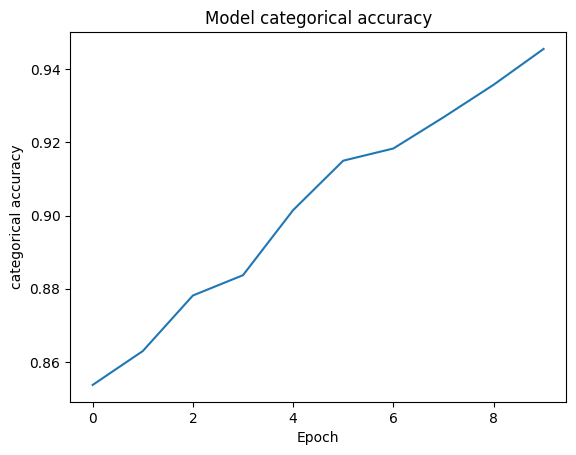

In [23]:
plt.plot(history.history['categorical_accuracy'])
plt.title('Model categorical accuracy')
plt.ylabel('categorical accuracy')
plt.xlabel('Epoch')
plt.show()

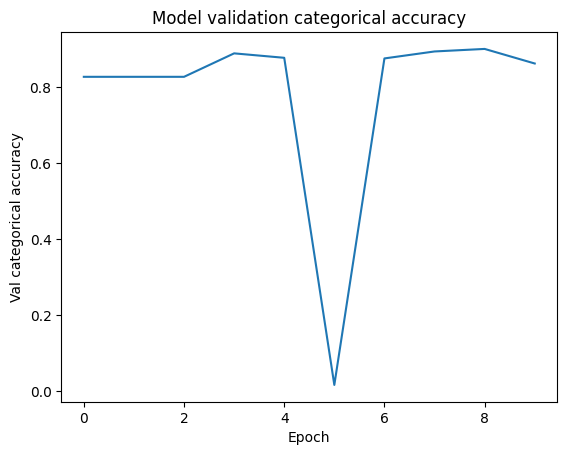

In [24]:
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model validation categorical accuracy')
plt.ylabel('Val categorical accuracy')
plt.xlabel('Epoch')
plt.show()

In [26]:
os.listdir(r"D:\DoAnChuyenNganh_TTNT\testimage")

[]

In [27]:
img = image.load_img(r"D:\DoAnChuyenNganh_TTNT\lfw_funneled\Serena_Williams\Serena_Williams_0052.jpg", target_size=(250, 250, 3))
x = image.img_to_array(img)
Xnew = x
#Xnew = preprocess_input(x)
Xtest = np.expand_dims(Xnew, axis=0)
ynew = model.predict(Xtest)
ynew

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


array([[4.5953278e-04, 9.5554900e-01, 6.8303091e-03, 1.4649361e-03,
        1.3984373e-03, 1.4904575e-04, 1.7825695e-03, 3.7744229e-03,
        3.7564663e-03, 4.7649676e-03, 3.7252359e-04, 1.9189203e-02,
        5.0870562e-04]], dtype=float32)

In [28]:
Xnew.shape

(250, 250, 3)

In [ ]:
#model = mobilenet.MobileNet(input_shape=(224, 224, 3),include_top=True, alpha=1., weights=None, classes=y.shape[1])
#model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy',
#              metrics=[categorical_crossentropy, categorical_accuracy, top_5_accuracy])

In [29]:
out_name = "model_50adamaug00002knopre"

#model.load_weights("../input/model-50/model_50.h5")

In [30]:
Xtest = np.expand_dims(Xnew, axis=0)
ynew = model.predict(Xtest)
ynew

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


array([[4.5953278e-04, 9.5554900e-01, 6.8303091e-03, 1.4649361e-03,
        1.3984373e-03, 1.4904575e-04, 1.7825695e-03, 3.7744229e-03,
        3.7564663e-03, 4.7649676e-03, 3.7252359e-04, 1.9189203e-02,
        5.0870562e-04]], dtype=float32)

In [31]:
ynew

array([[4.5953278e-04, 9.5554900e-01, 6.8303091e-03, 1.4649361e-03,
        1.3984373e-03, 1.4904575e-04, 1.7825695e-03, 3.7744229e-03,
        3.7564663e-03, 4.7649676e-03, 3.7252359e-04, 1.9189203e-02,
        5.0870562e-04]], dtype=float32)

In [32]:
# Create a converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Set quantize to true 
#converter.post_training_quantize=True
# Convert the model
tflite_model = converter.convert()
# Create the tflite model file
tflite_model_name = out_name+".tflite"
open(tflite_model_name, "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmps3r1orfg\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmps3r1orfg\assets


Saved artifact at 'C:\Users\Admin\AppData\Local\Temp\tmps3r1orfg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 13), dtype=tf.float32, name=None)
Captures:
  2367328440864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2367374548784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2367374553712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2367374548432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2367374550720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2367374556528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2376391560000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2376391558240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2376391560528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2376391560176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2367

12854496

In [ ]:
#label_encoder.inverse_transform(df['name'])

In [34]:
model_json = model.to_json()
with open(out_name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(out_name+".weights.h5")

In [35]:
tf.saved_model.save(model, out_name+"_saved")

INFO:tensorflow:Assets written to: model_50adamaug00002knopre_saved\assets


INFO:tensorflow:Assets written to: model_50adamaug00002knopre_saved\assets


In [37]:
import tarfile

def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))
        
make_tarfile(out_name+"Tar", r"D:\DoAnChuyenNganh_TTNT\AI\algorithm\model_50adamaug00002knopre_saved")

In [39]:
# Create a converter
converter = tf.lite.TFLiteConverter.from_saved_model(r"D:\DoAnChuyenNganh_TTNT\AI\algorithm\model_50adamaug00002knopre_saved")
# Set quantize to true 
#converter.post_training_quantize=True
# Convert the model
tflite_model = converter.convert()
# Create the tflite model file
tflite_model_name = out_name+"fromSaved.tflite"
open(tflite_model_name, "wb").write(tflite_model)

97568

In [41]:
model.save(out_name+".keras", include_optimizer=True)